# BO without Derivatives for Gamma point bandgap optimization (silicon)

In [25]:
import os
from matplotlib import pyplot as plt

%matplotlib inline


julia_runtime_path = "/home/travelle/julia"
julia_molsim_folder = "/home/travelle/Dev/JuliaMolSim/"

In [26]:
from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor

import plotly.io as pio

# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

In [27]:
### BO Parameters

In [29]:
# Parameters
N_TRIALS_INIT = 3 # Number of initial random trials to fit the GP.
NUM_EVALS_BO =  20 # Number of BO steps.

## Define the GP surrogate

In [30]:
class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        # NOTE: This ignores train_Yvar and uses inferred noise instead.
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [31]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate


ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        # mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
)

## Set up the experiment

In [32]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=N_TRIALS_INIT,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

In [33]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Branin


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": "x-stress",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would be inferred as an integer range.
            "bounds": [-0.2, 0.3],
        },
        {
            "name": "y-stress",
            "type": "range",
            "bounds": [-0.2, 0.3],
        },
    ],
    objectives={
        "gammaP_bandgap": ObjectiveProperties(minimize=True),
    },
)

[INFO 05-16 14:33:36] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-16 14:33:36] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x-stress. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-16 14:33:36] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter y-stress. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-16 14:33:36] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x-stress', parameter_type=FLOAT, range=[-0.2, 0.2]), RangeParameter(name='y-stress', parameter_type=FLOAT, range=[-0.2, 0.2])], parameter_constraint

## Set up the function to optimize (Julia)

In [34]:
import numpy as np
from julia import Julia
jl = Julia(runtime=julia_runtime_path, compiled_modules=False)

# Load InverseDesign.jl
from julia import Pkg, Main
pkg_path = os.path.join(julia_molsim_folder, "InverseDesign.jl/")
Pkg.activate(pkg_path)
Pkg.resolve()
Pkg.instantiate()

%load_ext julia.magic
%julia using InverseDesign

  Activating project at `~/Dev/JuliaMolSim/InverseDesign.jl`
  No Changes to `~/Dev/JuliaMolSim/InverseDesign.jl/Project.toml`
  No Changes to `~/Dev/JuliaMolSim/InverseDesign.jl/Manifest.toml`


The julia.magic extension is already loaded. To reload it, use:
  %reload_ext julia.magic


In [35]:
%julia gammaP_bandgap_vs_strain12 = construct_gammaP_bandgap_vs_strain12()
target = 0.05
def evaluate(parameters):
    # Only vary stress along x and y.
    x = np.array(np.squeeze([[parameters.get(f"x-stress"), parameters.get("y-stress")] + [0, 0, 0, 0]]))
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    bandgap_w_grad = %julia gammaP_bandgap_vs_strain12($x)
    bandgap, bandgap_grad = bandgap_w_grad[0], bandgap_w_grad[1:]
    loss = np.abs(bandgap - target) # optimize to target value.
    return {"gammaP_bandgap": (loss, float("nan"))}

### Running the Initialization (SOBOL)

In [36]:
for i in range(N_TRIALS_INIT):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 05-16 14:33:52] ax.service.ax_client: Generated new trial 0 with parameters {'x-stress': -0.068085, 'y-stress': 0.107808} using model Sobol.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.914430886358                   -0.70    5.1    7.83s
  2   -7.919512609688       -2.29       -1.35    1.0    1.81s
  3   -7.919910421419       -3.40       -2.30    2.2    4.02s
  4   -7.919930350249       -4.70       -3.28    2.3    4.21s
  5   -7.919930708396       -6.45       -3.72    3.7    5.24s
  6   -7.919930725767       -7.76       -4.71    1.9    3.23s
  7   -7.919930726835       -8.97       -5.37    3.2    5.86s
  8   -7.919930726845      -11.02       -6.46    2.5    3.97s
  9   -7.919930726845      -12.31       -6.84    3.5    4.40s
 10   -7.919930726845      -13.69       -7.44    1.9    3.45s
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.914423114961                   -0.70    5.1    9.34s
  2   -7.919518051111       -2.29       -1.35    1.0    1.62s
  3   -7.9

[INFO 05-16 14:46:42] ax.service.ax_client: Completed trial 0 with data: {'gammaP_bandgap': (0.016097, nan)}.
[INFO 05-16 14:46:42] ax.service.ax_client: Generated new trial 1 with parameters {'x-stress': 0.105573, 'y-stress': 0.013096} using model Sobol.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.913591743851                   -0.72    5.3    10.2s
  2   -7.917372659674       -2.42       -1.53    1.0    2.89s
  3   -7.917549629930       -3.75       -2.39    1.7    5.35s
  4   -7.917574958452       -4.60       -3.11    2.1    4.09s
  5   -7.917575270559       -6.51       -3.62    2.0    3.87s
  6   -7.917575308770       -7.42       -4.61    2.0    3.35s
  7   -7.917575310431       -8.78       -5.37    2.6    4.74s
  8   -7.917575310442      -10.95       -5.82    2.1    4.65s
  9   -7.917575310443      -12.09       -6.79    1.8    4.06s
 10   -7.917575310443      -13.13       -7.31    2.3    3.70s
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.913603471351                   -0.72    5.3    7.20s
  2   -7.917374413934       -2.42       -1.53    1.0    3.58s
  3   -7.9

[INFO 05-16 14:58:44] ax.service.ax_client: Completed trial 1 with data: {'gammaP_bandgap': (0.006005, nan)}.
[INFO 05-16 14:58:44] ax.service.ax_client: Generated new trial 2 with parameters {'x-stress': -0.086796, 'y-stress': 0.009413} using model Sobol.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.917822068229                   -0.67    5.4    7.99s
  2   -7.924254228933       -2.19       -1.35    1.0    2.00s
  3   -7.924578838630       -3.49       -2.28    2.3    3.16s
  4   -7.924600010465       -4.67       -2.98    2.2    4.13s
  5   -7.924601371624       -5.87       -3.39    2.6    4.42s
  6   -7.924601432912       -7.21       -3.51    1.7    2.42s
  7   -7.924601470209       -7.43       -3.63    1.0    2.07s
  8   -7.924601492967       -7.64       -3.79    1.0    2.05s
  9   -7.924601503444       -7.98       -4.01    1.1    2.17s
 10   -7.924601506385       -8.53       -4.27    1.3    3.02s
 11   -7.924601507333       -9.02       -4.78    1.6    3.25s
 12   -7.924601507419      -10.07       -5.18    2.0    2.24s
 13   -7.924601507457      -10.42       -5.50    1.6    3.06s
 14   -7.924601507462      -11.32       -5.68    1.7    4.08s
 15   -7.

[INFO 05-16 15:11:10] ax.service.ax_client: Completed trial 2 with data: {'gammaP_bandgap': (0.028771, nan)}.


### Viewing the evaluated trials

In [37]:
ax_client.get_trials_data_frame()

[WARNING 05-16 15:11:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,gammaP_bandgap,x-stress,y-stress
0,0,0_0,COMPLETED,Sobol,0.016097,-0.068085,0.107808
1,1,1_0,COMPLETED,Sobol,0.006005,0.105573,0.013096
2,2,2_0,COMPLETED,Sobol,0.028771,-0.086796,0.009413


In [38]:
parameters, values = ax_client.get_best_parameters()
print(f"Best parameters: {parameters}")
print(f"Corresponding mean: {values[0]}, covariance: {values[1]}")

Best parameters: {'x-stress': 0.10557264760136603, 'y-stress': 0.013096499815583224}
Corresponding mean: {'gammaP_bandgap': 0.006004686927171279}, covariance: {'gammaP_bandgap': {'gammaP_bandgap': nan}}


### Run the BO loop

In [39]:
for i in range(NUM_EVALS_BO):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 05-16 15:11:11] ax.service.ax_client: Generated new trial 3 with parameters {'x-stress': -0.177211, 'y-stress': -0.144298} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.857433226398                   -0.61    5.3    4.80s
  2   -7.865918788118       -2.07       -1.01    1.0    1.88s
  3   -7.867379256054       -2.84       -1.52    2.3    4.02s
  4   -7.867401503866       -4.65       -2.08    1.0    2.17s
  5   -7.867399357325   +   -5.67       -2.22    1.8    2.12s
  6   -7.867444897345       -4.34       -2.86    1.1    1.85s
  7   -7.867445228138       -6.48       -3.12    2.3    3.17s
  8   -7.867445381572       -6.81       -3.27    1.2    1.81s
  9   -7.867445460162       -7.10       -3.38    1.0    1.65s
 10   -7.867445436218   +   -7.62       -3.34    1.0    1.71s
 11   -7.867445498947       -7.20       -3.44    1.0    1.99s
 12   -7.867445590814       -7.04       -3.84    1.0    1.68s
 13   -7.867445582562   +   -8.08       -3.75    1.0    1.82s
 14   -7.867445584178       -8.79       -3.99    1.0    2.04s
 15   -7.

[INFO 05-16 15:21:48] ax.service.ax_client: Completed trial 3 with data: {'gammaP_bandgap': (0.013314, nan)}.
[INFO 05-16 15:21:59] ax.service.ax_client: Generated new trial 4 with parameters {'x-stress': 0.2, 'y-stress': -0.2} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.900331143222                   -0.73    5.5    6.87s
  2   -7.903489123021       -2.50       -1.02    1.0    3.24s
  3   -7.904759436176       -2.90       -1.47    2.1    5.14s
  4   -7.904994341037       -3.63       -2.35    1.1    2.78s
  5   -7.905003293182       -5.05       -2.58    2.6    4.16s
  6   -7.905006902149       -5.44       -3.25    1.5    3.40s
  7   -7.905007178466       -6.56       -3.28    2.1    3.97s
  8   -7.905007196332       -7.75       -3.34    1.0    2.23s
  9   -7.905007209091       -7.89       -3.42    1.0    2.83s
 10   -7.905007225664       -7.78       -3.62    1.0    2.54s
 11   -7.905007234165       -8.07       -3.79    1.0    3.41s
 12   -7.905007241585       -8.13       -4.13    1.2    1.76s
 13   -7.905007242679       -8.96       -4.21    1.5    2.57s
 14   -7.905007243290       -9.21       -4.29    1.1    3.04s
 15   -7.

[INFO 05-16 15:38:11] ax.service.ax_client: Completed trial 4 with data: {'gammaP_bandgap': (0.038359, nan)}.
[INFO 05-16 15:38:27] ax.service.ax_client: Generated new trial 5 with parameters {'x-stress': 0.2, 'y-stress': 0.2} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.869414182234                   -0.79    5.0    10.4s
  2   -7.871353348547       -2.71       -1.30    1.0    4.27s
  3   -7.871668006078       -3.50       -1.90    1.9    6.94s
  4   -7.871691091803       -4.64       -2.58    1.2    6.32s
  5   -7.871694041024       -5.53       -3.07    2.0    5.56s
  6   -7.871694239694       -6.70       -3.07    1.7    8.46s
  7   -7.871694287406       -7.32       -3.41    1.0    7.88s
  8   -7.871694291591       -8.38       -3.45    1.0    3.92s
  9   -7.871694301156       -8.02       -4.24    1.0    5.07s
 10   -7.871694302086       -9.03       -4.46    2.0    8.14s
 11   -7.871694302117      -10.51       -4.45    1.0    5.22s
 12   -7.871694302169      -10.28       -4.88    1.0    4.25s
 13   -7.871694302193      -10.61       -5.41    1.0    4.81s
 14   -7.871694302194      -12.38       -5.32    1.2    6.07s
 15   -7.

[INFO 05-16 16:06:22] ax.service.ax_client: Completed trial 5 with data: {'gammaP_bandgap': (0.018257, nan)}.
[INFO 05-16 16:06:24] ax.service.ax_client: Generated new trial 6 with parameters {'x-stress': 0.163582, 'y-stress': -0.042999} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.905529964855                   -0.73    5.2    9.50s
  2   -7.909421028304       -2.41       -1.25    1.0    3.49s
  3   -7.910106957427       -3.16       -2.11    2.1    6.30s
  4   -7.910120455389       -4.87       -2.93    1.9    5.48s
  5   -7.910122148019       -5.77       -3.23    2.7    5.43s
  6   -7.910122208526       -7.22       -3.68    1.4    5.00s
  7   -7.910122215404       -8.16       -4.38    2.1    6.39s
  8   -7.910122216293       -9.05       -4.87    2.4    6.21s
  9   -7.910122216345      -10.29       -5.75    2.0    7.99s
 10   -7.910122216351      -11.28       -6.46    2.9    11.7s
 11   -7.910122216351      -12.76       -6.66    2.5    9.77s
 12   -7.910122216351      -14.21       -6.94    1.0    7.00s
 13   -7.910122216351      -14.21       -8.31    1.4    6.92s
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ----

[INFO 05-16 16:26:00] ax.service.ax_client: Completed trial 6 with data: {'gammaP_bandgap': (0.002349, nan)}.
[INFO 05-16 16:26:00] ax.service.ax_client: Generated new trial 7 with parameters {'x-stress': 0.011523, 'y-stress': 0.059446} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.919173998648                   -0.71    5.3    5.34s
  2   -7.923426761209       -2.37       -1.51    1.0    2.07s
  3   -7.923601802740       -3.76       -2.46    1.7    4.06s
  4   -7.923625757947       -4.62       -3.10    2.2    7.69s
  5   -7.923626088846       -6.48       -3.77    1.9    4.07s
  6   -7.923626115451       -7.58       -4.77    2.1    5.61s
  7   -7.923626116093       -9.19       -5.86    2.6    5.79s
  8   -7.923626116101      -11.13       -6.16    3.0    6.96s
  9   -7.923626116101      -12.58       -7.25    1.2    4.03s
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.919168768717                   -0.71    5.4    8.79s
  2   -7.923426172919       -2.37       -1.51    1.0    4.24s
  3   -7.923601907475       -3.76       -2.46    1.7    5.42s
  4   -7.9

[INFO 05-16 16:40:10] ax.service.ax_client: Completed trial 7 with data: {'gammaP_bandgap': (0.030058, nan)}.
[INFO 05-16 16:40:21] ax.service.ax_client: Generated new trial 8 with parameters {'x-stress': 0.2, 'y-stress': -0.094766} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.900084707188                   -0.74    5.2    11.0s
  2   -7.903555917821       -2.46       -1.06    1.0    5.52s
  3   -7.904574702573       -2.99       -1.62    2.1    6.41s
  4   -7.904620635911       -4.34       -2.18    1.0    4.80s
  5   -7.904583795863   +   -4.43       -2.17    2.0    6.36s
  6   -7.904665639282       -4.09       -2.89    1.0    9.71s
  7   -7.904667750945       -5.68       -3.43    2.0    9.69s
  8   -7.904667758840       -8.10       -3.45    2.0    6.79s
  9   -7.904667759629       -9.10       -3.50    1.0    6.11s
 10   -7.904667768253       -8.06       -3.56    1.0    6.48s
 11   -7.904667793332       -7.60       -3.68    1.0    5.84s
 12   -7.904667824607       -7.50       -3.91    1.0    5.00s
 13   -7.904667837849       -7.88       -4.18    1.0    6.85s
 14   -7.904667836720   +   -8.95       -4.20    1.1    6.18s
 15   -7.

[INFO 05-16 17:07:20] ax.service.ax_client: Completed trial 8 with data: {'gammaP_bandgap': (0.016213, nan)}.
[INFO 05-16 17:07:22] ax.service.ax_client: Generated new trial 9 with parameters {'x-stress': -0.2, 'y-stress': 0.156442} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.904759372353                   -0.71    5.5    10.9s
  2   -7.908277735130       -2.45       -1.07    1.0    3.73s
  3   -7.909210911415       -3.03       -1.49    2.1    5.97s
  4   -7.909406238819       -3.71       -2.26    1.0    5.14s
  5   -7.909412162736       -5.23       -2.76    2.2    7.07s
  6   -7.909413004347       -6.07       -3.06    1.9    5.35s
  7   -7.909413095881       -7.04       -3.26    1.3    6.41s
  8   -7.909413117903       -7.66       -3.40    1.1    5.83s
  9   -7.909413122361       -8.35       -3.44    1.0    5.93s
 10   -7.909413126495       -8.38       -3.60    1.0    4.13s
 11   -7.909413128065       -8.80       -3.71    1.0    5.64s
 12   -7.909413129450       -8.86       -4.04    1.0    5.99s
 13   -7.909413129801       -9.46       -4.46    1.5    4.22s
 14   -7.909413129982       -9.74       -4.58    1.4    5.83s
 15   -7.

[INFO 05-16 17:26:41] ax.service.ax_client: Completed trial 9 with data: {'gammaP_bandgap': (0.020756, nan)}.
[INFO 05-16 17:26:44] ax.service.ax_client: Generated new trial 10 with parameters {'x-stress': 0.136884, 'y-stress': -0.171975} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.906734614918                   -0.70    5.5    10.2s
  2   -7.910361643494       -2.44       -1.03    1.0    4.29s
  3   -7.912261157482       -2.72       -1.57    2.2    5.22s
  4   -7.912324532382       -4.20       -2.30    1.0    4.68s
  5   -7.912330550219       -5.22       -2.48    2.5    6.20s
  6   -7.912343473518       -4.89       -2.89    1.1    3.33s
  7   -7.912345015291       -5.81       -3.18    1.2    6.57s
  8   -7.912345187971       -6.76       -3.25    1.4    4.95s
  9   -7.912345285932       -7.01       -3.31    1.0    4.69s
 10   -7.912345250757   +   -7.45       -3.29    1.0    5.44s
 11   -7.912345285388       -7.46       -3.31    1.0    3.71s
 12   -7.912345484667       -6.70       -3.48    1.0    4.96s
 13   -7.912345438499   +   -7.34       -3.42    1.0    5.12s
 14   -7.912345596958       -6.80       -3.71    1.0    3.61s
 15   -7.

[INFO 05-16 17:46:15] ax.service.ax_client: Completed trial 10 with data: {'gammaP_bandgap': (0.007534, nan)}.
/home/travelle/Envs/inverseDesign/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 05-16 17:46:20] ax.service.ax_client: Generated new trial 11 with parameters {'x-stress': -0.2, 'y-stress': -0.2} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.814917730442                   -0.60    5.3    8.79s
  2   -7.823178619574       -2.08       -0.88    1.0    2.80s
  3   -7.825961618662       -2.56       -1.18    2.3    4.58s
  4   -7.826407843387       -3.35       -1.68    1.4    3.33s
  5   -7.826466042599       -4.24       -2.12    1.1    2.80s
  6   -7.826474882061       -5.05       -2.56    1.9    5.37s
  7   -7.826477572272       -5.57       -2.88    2.0    4.46s
  8   -7.826478083127       -6.29       -3.25    1.6    3.42s
  9   -7.826478132952       -7.30       -3.32    1.6    4.35s
 10   -7.826478163300       -7.52       -3.50    1.0    4.93s
 11   -7.826478176706       -7.87       -3.81    1.1    3.35s
 12   -7.826478178404       -8.77       -4.12    1.6    2.82s
 13   -7.826478178547       -9.85       -4.35    1.4    2.73s
 14   -7.826478178598      -10.29       -4.57    1.2    3.01s
 15   -7.

[INFO 05-16 17:58:03] ax.service.ax_client: Completed trial 11 with data: {'gammaP_bandgap': (0.04551, nan)}.
[INFO 05-16 17:58:14] ax.service.ax_client: Generated new trial 12 with parameters {'x-stress': -0.135138, 'y-stress': 0.2} using model BoTorch.


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.902111108741                   -0.74    5.1    8.12s
  2   -7.904735846434       -2.58       -1.08    1.0    3.58s
  3   -7.905734246092       -3.00       -1.66    2.2    5.87s
  4   -7.905741335743       -5.15       -2.13    1.0    4.74s
  5   -7.905741555996       -6.66       -2.37    1.7    4.16s
  6   -7.905772977981       -4.50       -3.25    1.3    3.61s
  7   -7.905773105987       -6.89       -3.30    2.6    3.65s
  8   -7.905773105523   +   -9.33       -3.33    1.0    2.72s
  9   -7.905773110926       -8.27       -3.41    1.0    3.41s
 10   -7.905773138072       -7.57       -3.52    1.0    4.14s
 11   -7.905773167135       -7.54       -3.67    1.0    6.27s
 12   -7.905773199606       -7.49       -3.88    1.0    4.36s
 13   -7.905773204984       -8.27       -4.02    1.1    3.79s
 14   -7.905773204895   +  -10.05       -4.28    1.0    5.72s
 15   -7.

[INFO 05-16 18:18:18] ax.service.ax_client: Completed trial 12 with data: {'gammaP_bandgap': (0.023779, nan)}.


### Plotting the response surface and optimization progress

[INFO 05-16 18:18:18] ax.service.ax_client: Retrieving contour plot with parameter 'x-stress' on X-axis and 'y-stress' on Y-axis, for metric 'gammaP_bandgap'. Remaining parameters are affixed to the middle of their range.


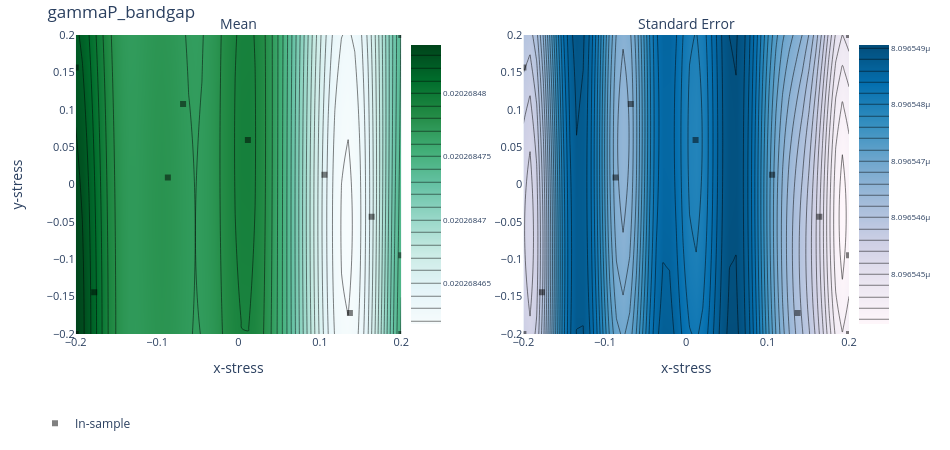

In [40]:
from ax.utils.notebook.plotting import render

render(ax_client.get_contour_plot())

In [41]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters, values[0]

[WARNING 05-16 18:18:19] ax.modelbridge.cross_validation: Metric gammaP_bandgap was unable to be reliably fit.
[WARNING 05-16 18:18:19] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-16 18:18:19] ax.service.utils.best_point: Model fit is poor and data on objective metric gammaP_bandgap is noisy; interpret best points results carefully.


({'x-stress': 0.16358188763263576, 'y-stress': -0.04299948887693711},
 {'gammaP_bandgap': 0.0023494776473238638})

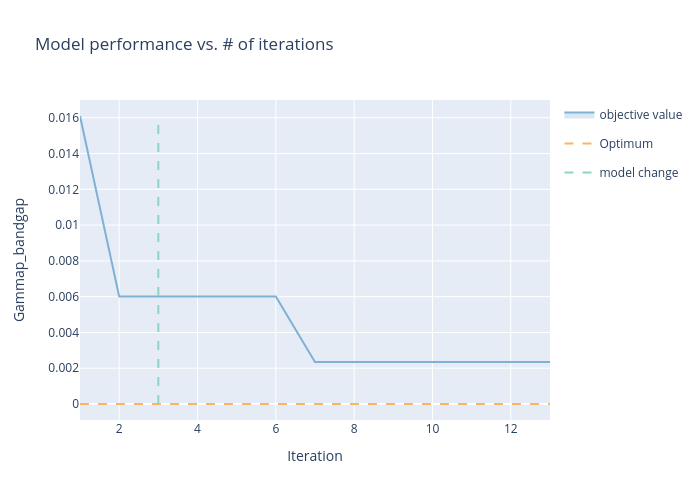

In [42]:
render(ax_client.get_optimization_trace(objective_optimum=0.0))

In [43]:
evaluate({"x-stress": 0.043193, "y-stress": -0.096975})

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.918129727307                   -0.68    5.4    8.21s
  2   -7.923337032281       -2.28       -1.30    1.0    4.38s
  3   -7.923878349531       -3.27       -2.18    2.3    6.10s
  4   -7.923902595096       -4.62       -2.98    2.0    4.76s
  5   -7.923903754502       -5.94       -3.59    2.7    5.62s
  6   -7.923903777963       -7.63       -3.93    2.3    5.81s
  7   -7.923903781800       -8.42       -5.01    1.3    6.18s
  8   -7.923903781945       -9.84       -5.52    3.2    7.85s
  9   -7.923903781946      -11.79       -6.22    2.1    9.71s
 10   -7.923903781947      -12.87       -7.46    2.5    5.94s
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.918142566956                   -0.68    5.4    8.52s
  2   -7.923337494718       -2.28       -1.30    1.0    3.73s
  3   -7.9

{'gammaP_bandgap': (0.02847083673998431, nan)}